## This is a group project for CAPP 30254: Machine Learning for Public Policy
## Done by: Big Brother Debunkers ##
**Team Member: Dingwei Liu, Qi Zhao**

**Topic: Fake News Detection**

In [131]:
# setting up the environment
import numpy as np # linear algebra
import pandas as pd # data processing
pd.set_option('display.max_colwidth', 100)
import re  # regular expression
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from bs4 import BeautifulSoup
import spacy
from scipy.stats import pearsonr

# Natural Language Toolkit
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer 
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import sent_tokenize

# TF-IDF (Term Frequency-Inverse Document Frequency) 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE, SelectKBest, mutual_info_classif
from sklearn.datasets import make_classification

from sklearn.svm import SVC

# Step One: Data Pre-processing and exploration

In [132]:
# Importing the dataset
data = pd.read_csv("data/train.csv", encoding = "UTF-8")

data = data.rename(columns={'title': 'title_raw'})
data = data.rename(columns={'text': 'text_raw'})

# check the first 5 rows of the dataset
data.head(15)

,id,title_raw,author,text_raw,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It By Darrell Luc...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - Breitbart",Daniel J. Flynn,Ever get the feeling your life circles the roundabout rather than heads in a straight line towar...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, 2016 \nThe tension between intelligence analysts a...",1
3,3,15 Civilians Killed In Single US Airstrike Have Been Identified,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstrike Have Been Identified The rate at which civilia...,1
4,4,Iranian woman jailed for fictional unpublished story about woman stoned to death for adultery,Howard Portnoy,Print \nAn Iranian woman has been sentenced to six years in prison after Iran’s Revolutionary Gu...,1
5,5,Jackie Mason: Hollywood Would Love Trump if He Bombed North Korea over Lack of Trans Bathrooms (...,Daniel Nussbaum,"In these trying times, Jackie Mason is the Voice of Reason. [In this week’s exclusive clip for B...",0
6,6,"Life: Life Of Luxury: Elton John’s 6 Favorite Shark Pictures To Stare At During Long, Transconti...",NaN,Ever wonder how Britain’s most iconic pop pianist gets through a long flight? Here are the six p...,1
7,7,Benoît Hamon Wins French Socialist Party’s Presidential Nomination - The New York Times,Alissa J. Rubin,"PARIS — France chose an idealistic, traditional candidate in Sunday’s primary to represent ...",0
8,8,Excerpts From a Draft Script for Donald Trump’s Q&ampA With a Black Church’s Pastor - The New Yo...,NaN,Donald J. Trump is scheduled to make a highly anticipated visit to an church in Detroit on Sat...,0
9,9,"A Back-Channel Plan for Ukraine and Russia, Courtesy of Trump Associates - The New York Times",Megan Twohey and Scott Shane,"A week before Michael T. Flynn resigned as national security adviser, a sealed proposal was to...",0


In [133]:
# check the shape of the dataset
data.shape

(20800, 5)

In [134]:
from langdetect import detect

def language_detect(x):
    try:
        return detect(x)
    except:
        return np.nan
data['language'] = data['text_raw'].map(language_detect)
data = data[data['language'] == 'en']
data['language'].value_counts()

language
en    20166
Name: count, dtype: int64

In [135]:
def split_title_source(x):
    if type(x) != str:
        return np.nan, np.nan
    parts = x.rsplit(' - ', 1)
    return parts[0], parts[1] if len(parts) > 1 else ''

data[['title', 'source']] = data['title_raw'].map(split_title_source).apply(pd.Series)

# Display the DataFrame to check the new 'source' column
print(data['title'].value_counts().head())
print(data['source'].value_counts().head())

title
The Dark Agenda Behind Globalism And Open Borders                                                               5
Get Ready For Civil Unrest: Survey Finds That Most Americans Are Concerned About Election Violence              5
EXCLUSIVE                                                                                                       5
Let’s Be Clear – A Vote For Warmonger Hillary Clinton Is A Vote For World War 3                                 4
Will Barack Obama Delay Or Suspend The Election If Hillary Is Forced Out By The New FBI Email Investigation?    4
Name: count, dtype: int64
source
                                10686
The New York Times               6221
Breitbart                        2338
America's Finest News Source       79
Russia News Now                    51
Name: count, dtype: int64


In [136]:
# check whether there are missing values in the dataset
data.isnull().sum()

id              0
title_raw     525
author       1745
text_raw        0
label           0
language        0
title         525
source        525
dtype: int64

In [137]:
# check the distribution of "label" in the dataset
data['label'].value_counts()

label
0    10384
1     9782
Name: count, dtype: int64

In [138]:
# Get the top 5 authors
top_authors = data['author'].value_counts().head(5)

# Get the top 5 sources
top_sources = data['source'].value_counts().head()

# Print the results
print("Top 5 authors:")
print(top_authors)
print("\nTop 5 sources:")
print(top_sources)

Top 5 authors:
author
Pam Key             243
admin               192
Jerome Hudson       166
Charlie Spiering    141
John Hayward        140
Name: count, dtype: int64

Top 5 sources:
source
                                10686
The New York Times               6221
Breitbart                        2338
America's Finest News Source       79
Russia News Now                    51
Name: count, dtype: int64


In [139]:
port_stem = PorterStemmer()
stop_words = set(stopwords.words('english'))

def stemming(content):
    if not isinstance(content, str):
        return ''
    content = BeautifulSoup(content, "html.parser").get_text()
    content = re.sub('[^a-zA-Z]', ' ', content).lower()
    words = content.split()
    stemmed_words = [port_stem.stem(word) for word in words if word not in stop_words]
    stemmed_content = ' '.join(stemmed_words)
    return stemmed_content

data['stemmed_title'] = data['title_raw'].apply(stemming)
data['stemmed_text'] = data['text_raw'].apply(stemming)

C:\Users\willi\AppData\Local\Temp\ipykernel_38904\2903697365.py:7: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  content = BeautifulSoup(content, "html.parser").get_text()
C:\Users\willi\AppData\Local\Temp\ipykernel_38904\2903697365.py:7: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  content = BeautifulSoup(content, "html.parser").get_text()
C:\Users\willi\AppData\Local\Temp\ipykernel_38904\2903697365.py:7: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  content = BeautifulSoup(content, "html.parser").get_text()


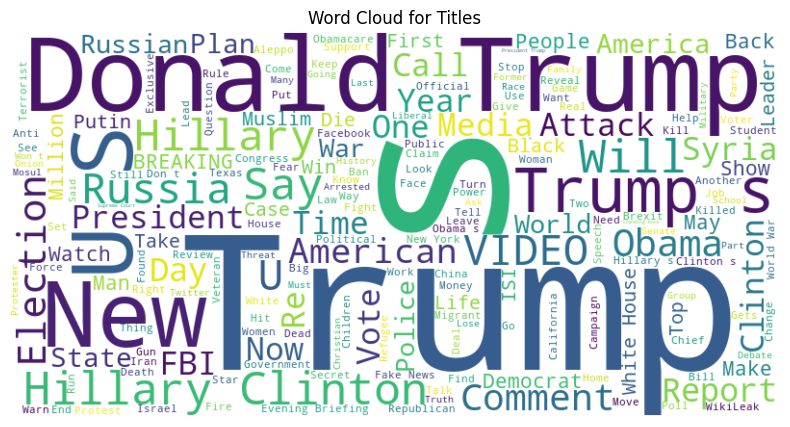

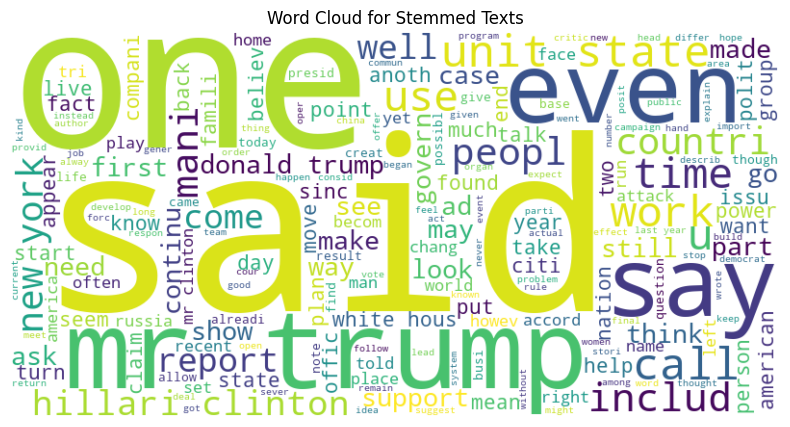

In [140]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# define a function to generate wordcloud
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

title_text = " ".join(text for text in data['title'].dropna())
text_text = " ".join(text for text in data['stemmed_text'].dropna())

generate_wordcloud(title_text, 'Word Cloud for Titles')

generate_wordcloud(text_text, 'Word Cloud for Stemmed Texts')

# Feature Engineering

## Feature extraction

In [141]:
def start_with_number(x):
    if type(x) != str or x == "":
        return False
    if x[0].isdigit():
        return True
    return False
data['start_with_number'] = data['title_raw'].map(start_with_number)
print('Ratio of start_with_number:')
print(data['start_with_number'].mean())

Ratio of start_with_number:
0.021372607358920957


In [142]:
def contain_q_e_mark(x):
    if type(x) != str:
        return False
    if "?" in x or "!" in x:
        return True
    return False
data['contain_q_e_mark'] = data['title_raw'].map(contain_q_e_mark)
print('Ratio of contain_q_e_mark:')
print(data['contain_q_e_mark'].mean())

Ratio of contain_q_e_mark:
0.08127541406327482


In [143]:
def all_words_are_capital(x):
    if type(x) != str:
        return False
    words = [''.join(filter(str.isalpha, word)) for word in x.split()]
    for word in words:
        if word and not word.isupper():
            return False
    return True
data['all_words_are_capital'] = data['title_raw'].map(all_words_are_capital)
print('Ratio of all_words_are_capital:')
print(data['all_words_are_capital'].mean())

Ratio of all_words_are_capital:
0.00758702767033621


In [144]:
def no_source(x):
    if type(x) != str:
        return True
    if x == "":
        return True
    return False
data['no_source'] = data['source'].map(no_source)
print('Ratio of no_source:')
print(data['no_source'].mean())

Ratio of no_source:
0.5559357334126748


In [145]:
def no_author(x):
    if type(x) != str:
        return True
    if x == "":
        return True
    return False
data['no_author'] = data['author'].map(no_source)
print('Ratio of no_author:')
print(data['no_author'].mean())

Ratio of no_author:
0.08653178617474958


In [146]:
def no_title(x):
    if type(x) != str:
        return True
    if x == "":
        return True
    return False
data['no_title'] = data['title'].map(no_title)
print('Ratio of no_title:')
print(data['no_title'].mean())

Ratio of no_title:
0.026033918476643856


In [75]:

# Load the SpaCy English model
nlp = spacy.load('en_core_web_sm')

# Load the SpaCy English model and disable unnecessary pipeline components
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def extract_words_features(texts):
    docs = nlp.pipe(texts)
    
    word_counts = []
    avg_word_lengths = []
    lengths_of_article = []
    number_counts = []
    adjective_counts = []
    
    for doc in docs:
        word_count = len([token for token in doc if token.is_alpha])
        avg_word_length = sum(len(token) for token in doc if token.is_alpha) / word_count if word_count > 0 else 0
        length_of_article = len(doc.text)
        number_count = len([token for token in doc if token.like_num])
        adjective_count = len([token for token in doc if token.pos_ == 'ADJ'])
        
        word_counts.append(word_count)
        avg_word_lengths.append(avg_word_length)
        lengths_of_article.append(length_of_article)
        number_counts.append(number_count)
        adjective_counts.append(adjective_count)
    
    return word_counts, avg_word_lengths, lengths_of_article, number_counts, adjective_counts

# Extract features in batches
word_counts, avg_word_lengths, lengths_of_article, number_counts, adjective_counts = extract_words_features(data['text_raw'])


In [76]:
metrics = {
    'word_counts': word_counts,
    'avg_word_lengths': avg_word_lengths,
    'lengths_of_article': lengths_of_article,
    'number_counts': number_counts,
    'adjective_counts': adjective_counts
}
df = pd.DataFrame(metrics)
df.to_csv('article_metrics.csv', index=False)

In [148]:
temp_table = pd.read_csv("article_metrics.csv")

In [149]:
word_counts = temp_table['word_counts']
avg_word_lengths = temp_table['avg_word_lengths']
lengths_of_article = temp_table['lengths_of_article']
number_counts = temp_table['number_counts']
adjective_counts = temp_table['adjective_counts']

In [150]:
# Add the features to the DataFrame
data['word_count'] = word_counts
data['avg_word_length'] = avg_word_lengths
data['length_of_article'] = lengths_of_article
data['number_count'] = number_counts
data['adjective_count'] = adjective_counts

print(f'word count average: {data["word_count"].mean()}')
print(f'word length average: {data["avg_word_length"].mean()}')
print(f'article length average: {data["length_of_article"].mean()}')
print(f'number count average: {data["number_count"].mean()}')
print(f'adjective word count average: {data["adjective_count"].mean()}')

word count average: 748.233094629156
word length average: 4.836686571632366
article length average: 4616.455140664962
number count average: 15.565780051150895
adjective word count average: 55.794782608695655


In [208]:
data = data.dropna(subset=["title_raw","text_raw"])

In [152]:
# Basic Count Features(1-gram, 2-gram, 3-gram)

def generate_ngrams(text, n):
    if not text.strip():
        return {}
    vectorizer = CountVectorizer(ngram_range=(n, n), stop_words='english')  
    try:
        ngrams = vectorizer.fit_transform([text])
        ngram_list = vectorizer.get_feature_names_out()
        ngram_counts = ngrams.toarray()[0]
        return dict(zip(ngram_list, ngram_counts))
    except ValueError:
        return {}

def calculate_ngram_features(title, content, n):
    title_ngrams = generate_ngrams(title, n)
    content_ngrams = generate_ngrams(content, n)
    
    title_ngram_count = sum(title_ngrams.values())
    title_unique_ngrams = len(title_ngrams)
    content_ngram_count = sum(content_ngrams.values())
    content_unique_ngrams = len(content_ngrams)
    
    common_ngrams = set(title_ngrams.keys()) & set(content_ngrams.keys())
    common_ngram_count = sum(min(title_ngrams[ng], content_ngrams[ng]) for ng in common_ngrams)
    
    title_to_content_ratio = common_ngram_count / title_ngram_count if title_ngram_count > 0 else 0
    
    return {
        f'{n}gram_title_count': title_ngram_count,
        f'{n}gram_title_unique': title_unique_ngrams,
        f'{n}gram_text_count': content_ngram_count,
        f'{n}gram_text_unique': content_unique_ngrams,
        f'{n}gram_common_count': common_ngram_count,
        f'{n}gram_title_to_content_ratio': title_to_content_ratio
    }

def extract_ngram_features(row):
    features = {}
    for n in range(1, 4):
        features.update(calculate_ngram_features(row['title_raw'], row['text_raw'], n))
    return pd.Series(features)

# Apply the extract_ngram_features function to each row
ngram_features = data.apply(extract_ngram_features, axis=1)

# Concatenate the ngram features with the original dataframe
data = pd.concat([data, ngram_features], axis=1)

# Ensure no column name duplication and calculate the correct averages
for n in range(1, 4):
    column_name = f'{n}gram_title_to_content_ratio'
    if column_name in data.columns:
        print(f'{n}-gram title to content ratio average: {data[column_name].mean()}')


1-gram title to content ratio average: 0.7287772665567469
2-gram title to content ratio average: 0.3901965314520158
3-gram title to content ratio average: 0.249846387797978


In [153]:
# calculate the sentiment of the title and text
class SentimentFeatureGenerator:

    def __init__(self, name='sentimentFeatureGenerator'):
        self.name = name
        self.sid = SentimentIntensityAnalyzer()

    def compute_sentiment(self, sentences):
        sentiments = [self.sid.polarity_scores(sentence) for sentence in sentences]
        sentiment_df = pd.DataFrame(sentiments)
        return sentiment_df.mean()

    def process(self, df):

        # Calculate sentiment for title
        df['title_sents'] = df['title_raw'].apply(sent_tokenize)
        df_title_sentiment = df['title_sents'].apply(lambda x: self.compute_sentiment(x))
        df = pd.concat([df, df_title_sentiment], axis=1)
        df.rename(columns={'compound': 'title_compound', 'neg': 'title_neg', 'neu': 'title_neu', 'pos': 'title_pos'}, inplace=True)

        # Calculate sentiment for text
        df['text_sents'] = df['text_raw'].apply(sent_tokenize)
        df_text_sentiment = df['text_sents'].apply(lambda x: self.compute_sentiment(x))
        df = pd.concat([df, df_text_sentiment], axis=1)
        df.rename(columns={'compound': 'text_compound', 'neg': 'text_neg', 'neu': 'text_neu', 'pos': 'text_pos'}, inplace=True)

        # Clean up intermediate columns
        df.drop(columns=['title_sents', 'text_sents'], inplace=True)

        return df

sfg = SentimentFeatureGenerator()
data = sfg.process(data)

print(data[['title_compound', 'title_neg', 'title_neu', 'title_pos', 'text_compound', 'text_neg', 'text_neu', 'text_pos']])


       title_compound  title_neg  title_neu  title_pos  text_compound  \
0              0.0000      0.000      1.000      0.000      -0.001730   
1              0.0000      0.000      1.000      0.000       0.019269   
2             -0.3182      0.330      0.459      0.211       0.066035   
3             -0.6705      0.333      0.667      0.000      -0.456200   
4             -0.7964      0.372      0.628      0.000      -0.397360   
...               ...        ...        ...        ...            ...   
20795          0.0000      0.000      1.000      0.000       0.041692   
20796          0.0000      0.000      1.000      0.000      -0.070280   
20797          0.0000      0.000      1.000      0.000       0.129546   
20798          0.0000      0.000      1.000      0.000      -0.001679   
20799          0.3818      0.000      0.606      0.394      -0.129287   

       text_neg  text_neu  text_pos  
0      0.038135  0.918000  0.043892  
1      0.083345  0.834759  0.081862  
2      0.

In [154]:
# calculate the polarity of the title and text
class PolarityFeatureGenerator:

    def __init__(self, name='polarityFeatureGenerator', lexicon_path='NRC-Emotion-Lexicon-Wordlevel-v0.92.txt'):
        self.name = name
        self.negative_words = self.load_lexicon(lexicon_path)

    def load_lexicon(self, lexicon_path):
        negative_words = set()
        with open(lexicon_path, 'r') as file:
            for line in file:
                word, emotion, association = line.strip().split('\t')
                if emotion == 'negative' and association == '1':
                    negative_words.add(word)
        return negative_words

    def compute_polarity(self, text):
        words = text.split()
        negative_count = sum(1 for word in words if word in self.negative_words)
        polarity = 'odd' if negative_count % 2 != 0 else 'even'
        return negative_count, polarity

    def process(self, df):
        # Calculate polarity for title
        df['title_negative_count'], df['title_polarity'] = zip(*df['title_raw'].apply(self.compute_polarity))

        # Calculate polarity for text
        df['text_negative_count'], df['text_polarity'] = zip(*df['text_raw'].apply(self.compute_polarity))

        return df

# Initialize the PolarityFeatureGenerator
pfg = PolarityFeatureGenerator(lexicon_path='data/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt')
data = pfg.process(data)

# Display the polarity features
print(data[['title_negative_count', 'title_polarity', 'text_negative_count', 'text_polarity']])


       title_negative_count title_polarity  text_negative_count text_polarity
0                         0           even                    6          even
1                         0           even                   18          even
2                         0           even                   22          even
3                         0           even                   34          even
4                         4           even                    8          even
...                     ...            ...                  ...           ...
20795                     0           even                    9           odd
20796                     0           even                   41           odd
20797                     0           even                    6          even
20798                     0           even                    7           odd
20799                     0           even                   37           odd

[19641 rows x 4 columns]


In [155]:
# transform the categorical polarity to numerical values
data['title_polarity'] = data['title_polarity'].map({'even': 0, 'odd': 1})
data['text_polarity'] = data['text_polarity'].map({'even': 0, 'odd': 1})

## Feature selection

In [157]:
# delete the features with high correlation and low information gain
info_gain_series = pd.Series(info_gain, index=X.columns)
corr_matrix = X.corr()

to_drop = set()
for i in range(len(corr_matrix)):
    for j in range(i + 1, len(corr_matrix)):
        if abs(corr_matrix.iloc[i, j]) > 0.9:  # set the threshold for correlation
            if info_gain[i] > info_gain[j]:
                to_drop.add(corr_matrix.columns[j])
            else:
                to_drop.add(corr_matrix.columns[i])

# delete the features with high correlation and low information gain
to_drop.update(info_gain_series[info_gain_series == 0].index)
X_filtered = X.drop(columns=to_drop)

print("Removed features due to high correlation or zero information gain:", to_drop)
print("Remaining features:", X_filtered.columns)

Removed features due to high correlation or zero information gain: {'no_title', '3gram_title_unique', '3gram_text_count', '2gram_text_count', '1gram_text_count', '1gram_title_count', 'adjective_count', '1gram_title_unique', 'text_negative_count', '2gram_common_count', '2gram_title_unique', 'length_of_article', '3gram_text_unique', '3gram_title_to_content_ratio', '1gram_text_unique', '3gram_title_count'}
Remaining features: Index(['start_with_number', 'contain_q_e_mark', 'all_words_are_capital',
       'no_source', 'no_author', 'word_count', 'avg_word_length',
       'number_count', '1gram_common_count', '1gram_title_to_content_ratio',
       '2gram_title_count', '2gram_text_unique',
       '2gram_title_to_content_ratio', '3gram_common_count', 'title_neg',
       'title_neu', 'title_pos', 'title_compound', 'text_neg', 'text_neu',
       'text_pos', 'text_compound', 'title_negative_count', 'title_polarity',
       'text_polarity'],
      dtype='object')


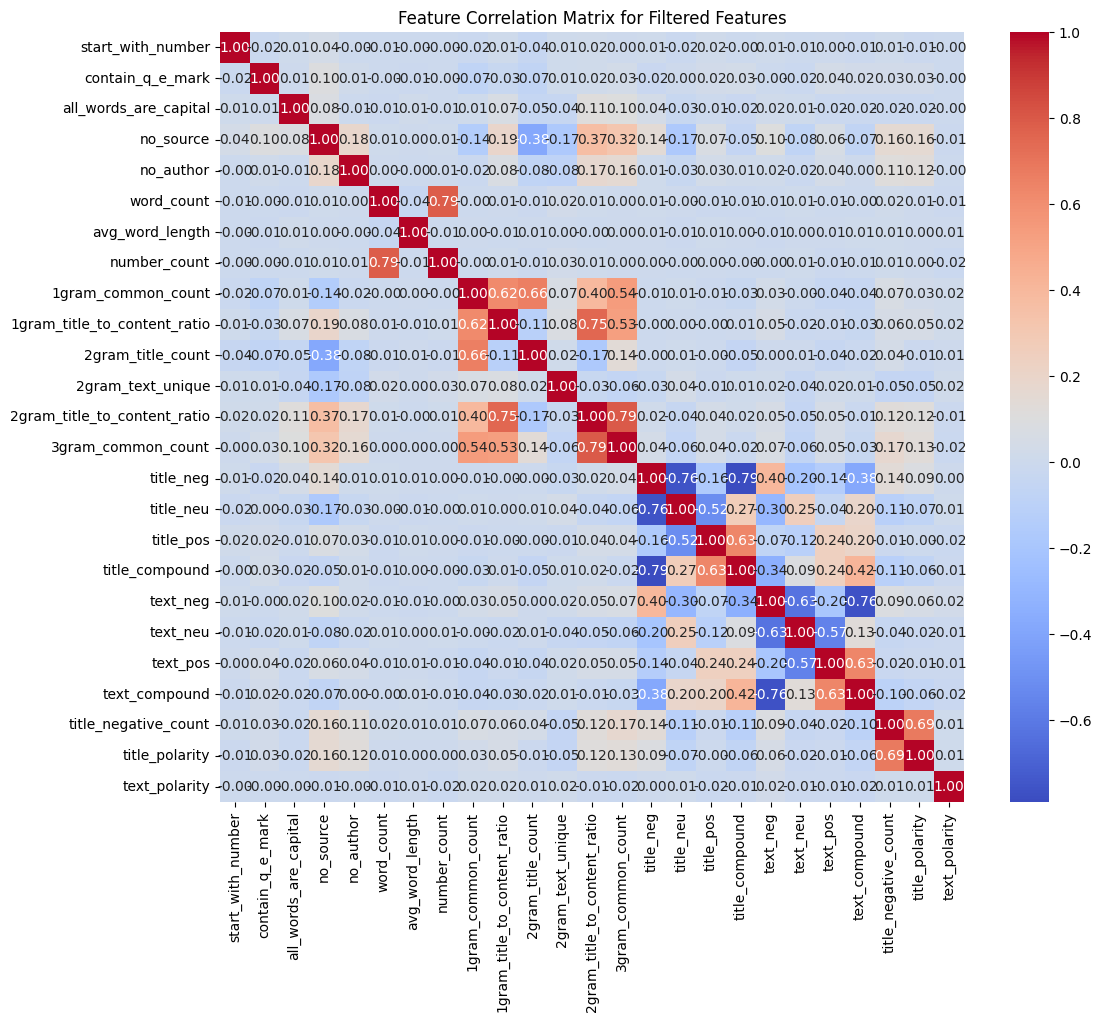

In [158]:
import seaborn as sns

corr_matrix = X_filtered.corr()

plt.figure(figsize=(12, 10))

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)

plt.title('Feature Correlation Matrix for Filtered Features')

plt.show()

In [ ]:
# 5-fold cross-validation
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Initialize the model
model = LogisticRegression(max_iter=1000)

# information gain feature selection
info_gain_selector = SelectKBest(mutual_info_classif, k='all')
info_gain_selector.fit(X_filtered, y)
info_gain_scores = info_gain_selector.scores_

# pearson correlation feature selection
pearson_corr = X_filtered.apply(lambda x: np.abs(np.corrcoef(x, y)[0, 1]))

# combine the scores
combined_scores = (info_gain_scores / np.max(info_gain_scores)) + (pearson_corr / np.max(pearson_corr))

# choose the top 20 features
k_top_features = 20
top_feature_indices = np.argsort(combined_scores)[-k_top_features:]
X_selected = X_filtered.iloc[:, top_feature_indices]

# Recursive Feature Elimination
rfe = RFE(estimator=model, n_features_to_select=10)
rfe.fit(X_selected, y)
rfe_selected_features = X_selected.columns[rfe.support_]

# select the final features
X_final = X_filtered[rfe_selected_features]

# cross-validation
scores = cross_val_score(model, X_final, y, cv=kf, scoring='accuracy')

# output the results
print("Accuracy of each fold: ", scores)
print("Average accuracy: ", np.mean(scores))
print("Selected feature names:", rfe_selected_features.tolist())

Accuracy of each fold:  [0.89259354 0.88212831 0.90325866 0.90224033 0.89663951]
Average accuracy:  0.8953720675389383
Selected feature names: ['all_words_are_capital', 'text_neg', 'contain_q_e_mark', 'text_pos', 'title_polarity', 'title_negative_count', 'no_author', '1gram_title_to_content_ratio', '2gram_title_to_content_ratio', 'no_source']


In [ ]:
# print the selected features and their corresponding scores
feature_names = X_filtered.columns
combined_scores_with_features = list(zip(feature_names, combined_scores))

for feature, score in combined_scores_with_features:
    print(f"{feature}: {score}")


start_with_number: 0.054748945342129755
contain_q_e_mark: 0.22062140645276457
all_words_are_capital: 0.1305452604103023
no_source: 2.0
no_author: 0.5713284891470087
avg_word_length: 0.0667277162345821
number_count: 0.18936582518084857
1gram_common_count: 0.32806177522484703
1gram_title_to_content_ratio: 0.6438399698835104
2gram_title_count: 0.7056282100285912
2gram_text_unique: 0.3052468915444828
2gram_title_to_content_ratio: 1.0885056535098805
3gram_common_count: 0.7984622644748746
title_neg: 0.1653523663053223
title_neu: 0.2420791678290277
title_pos: 0.13038573513680543
title_compound: 0.07257041127116144
text_neg: 0.1938723663008251
text_neu: 0.22064554085310883
text_pos: 0.230661420288778
text_compound: 0.11361821575173742
title_negative_count: 0.33980822976570707
title_polarity: 0.3257485098119013
text_polarity: 0.04884167408814645


In [ ]:
# data['content'] = data['content'].values
data['stemmed_text'] = data['stemmed_text'].values
data['label'] = data['label'].values
data.dropna(subset=['stemmed_text'])
vectorizer = TfidfVectorizer()

X_tfidf = vectorizer.fit_transform(data['stemmed_text'].values.astype('U'))

## Feature Union

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from scipy.sparse import hstack,csr_matrix

numeric_features = data[rfe_selected_features].values
imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()
X_num = scaler.fit_transform(imputer.fit_transform(numeric_features))

X_num_sparse = csr_matrix(X_num)

In [ ]:
X_combined = hstack([X_tfidf, X_num_sparse])

# Classification

In [ ]:
# Get X and y values
# X = X

def split(X,y):
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42)
    return X_train, X_val, X_test, y_train, y_val, y_test

class MLDataSet:
    def __init__(self, X_train, X_val, X_test, y_train, y_val, y_test):
        self.X_train = X_train
        self.X_val = X_val
        self.X_test = X_test
        self.y_train = y_train
        self.y_val = y_val
        self.y_test = y_test

X_train, X_val, X_test, y_train, y_val, y_test = split(X_tfidf, data['label'])
tfidf = MLDataSet(X_train, X_val, X_test, y_train, y_val, y_test)

X_train, X_val, X_test, y_train, y_val, y_test = split(X_combined, data['label'])
combined = MLDataSet(X_train, X_val, X_test, y_train, y_val, y_test)

# X_combined_train, y_combined_train, X_combined_val, y_combined_val, X_combined_test, y_combined_test = split(X_combined,data['label'])


In [ ]:
data.keys()

Index(['id', 'title_raw', 'author', 'text_raw', 'label', 'language', 'title',
       'source', 'stemmed_title', 'stemmed_text', 'start_with_number',
       'contain_q_e_mark', 'all_words_are_capital', 'no_source', 'no_author',
       'no_title', 'word_count', 'avg_word_length', 'length_of_article',
       'number_count', 'adjective_count', '1gram_title_count',
       '1gram_title_unique', '1gram_text_count', '1gram_text_unique',
       '1gram_common_count', '1gram_title_to_content_ratio',
       '2gram_title_count', '2gram_title_unique', '2gram_text_count',
       '2gram_text_unique', '2gram_common_count',
       '2gram_title_to_content_ratio', '3gram_title_count',
       '3gram_title_unique', '3gram_text_count', '3gram_text_unique',
       '3gram_common_count', '3gram_title_to_content_ratio', 'title_neg',
       'title_neu', 'title_pos', 'title_compound', 'text_neg', 'text_neu',
       'text_pos', 'text_compound', 'title_negative_count', 'title_polarity',
       'text_negative_count',

In [ ]:
from sklearn.svm import SVC
def svc_model(d):
    svc = SVC()
    svc.fit(d.X_train, d.y_train)
    y_pred = svc.predict(d.X_test)
    print("accuracy_score",accuracy_score(d.y_test,  y_pred))
    print("precision_score", precision_score(d.y_test, y_pred))
    print("recall_score", recall_score(d.y_test, y_pred))
    print("f1_score",f1_score(d.y_test, y_pred))
    print("roc_auc_score",roc_auc_score(d.y_test, y_pred))

print("tfidf")
svc_model(tfidf)
print("combined")
svc_model(combined)

tfidf
accuracy_score 0.9495926680244399
precision_score 0.9303062302006336
recall_score 0.9638949671772429
f1_score 0.9468027941966685
roc_auc_score 0.9505189121600501
combined
accuracy_score 0.960285132382892
precision_score 0.94
recall_score 0.9770240700218819
f1_score 0.9581545064377682
roc_auc_score 0.9613691778680837


In [ ]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train,  y_train)
y_pred = svc.predict(X_test)
print(accuracy_score(y_test,  y_pred))
print(f1_score(y_test, y_pred))
print(roc_auc_score(d.y_test, y_pred))

0.960285132382892
0.9581545064377682


In [192]:
from sklearn.linear_model import LogisticRegression
def lr_model(d, C=1.0, max_iter=1000,show=True,penalty='l2'):
    lr = LogisticRegression(C=C, max_iter=max_iter, penalty=penalty)
    lr.fit(d.X_train, d.y_train)
    y_pred = lr.predict(d.X_test)
    if show:
        print("accuracy_score",accuracy_score(d.y_test,  y_pred))
        print("precision_score", precision_score(d.y_test, y_pred))
        print("recall_score", recall_score(d.y_test, y_pred))
        print("f1_score",f1_score(d.y_test, y_pred))
        print("roc_auc_score",roc_auc_score(d.y_test, y_pred))
    y_train_pred = lr.predict(d.X_train)
    y_val_pred = lr.predict(d.X_val)
    return accuracy_score(d.y_train,  y_train_pred), accuracy_score(d.y_val,  y_val_pred), accuracy_score(d.y_test,  y_pred)

print("tfidf")
lr_model(tfidf)
print("combined")
lr_model(combined)

tfidf
accuracy_score 0.9389002036659878
precision_score 0.921443736730361
recall_score 0.949671772428884
f1_score 0.9353448275862069
roc_auc_score 0.9395977909763468
combined
accuracy_score 0.9613034623217923
precision_score 0.9438559322033898
recall_score 0.9748358862144421
f1_score 0.9590958019375673
roc_auc_score 0.9621798478691258


(0.9796334012219959, 0.9595316874522779, 0.9613034623217923)

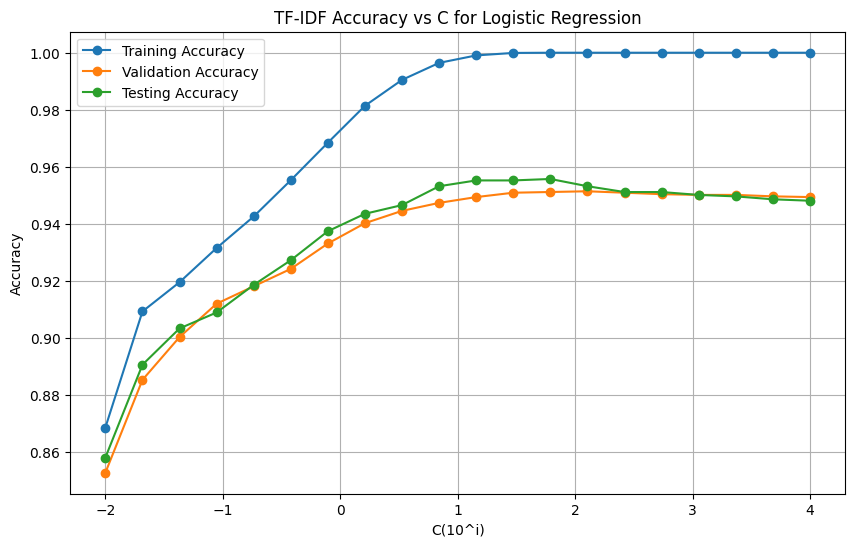

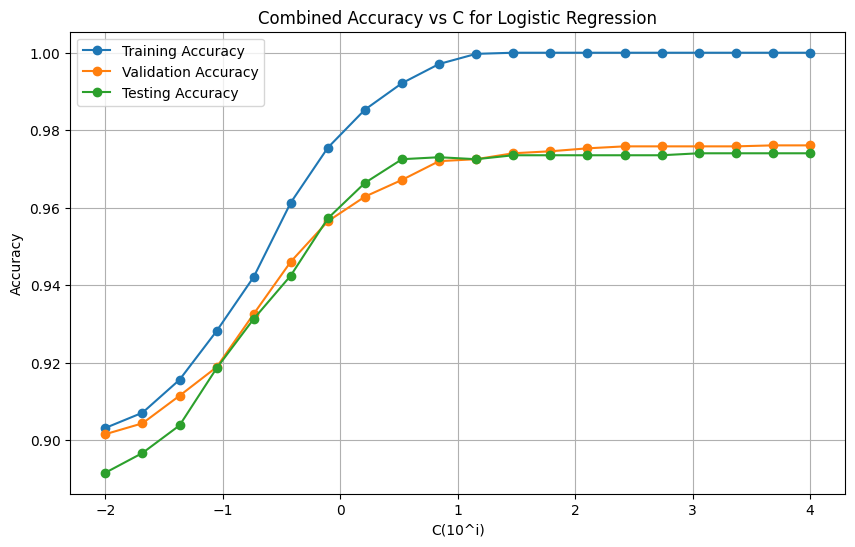

In [205]:
train_accuracies = []
val_accuracies = []
test_accuracies = []

C = np.logspace(-2, 4, num=20)
log10_C = np.log10(C)
for i in C:
    train, val, test = lr_model(tfidf, C=i, show=False)
    train_accuracies.append(train)
    val_accuracies.append(val)
    test_accuracies.append(test)

plt.figure(figsize=(10, 6))
plt.plot(log10_C, train_accuracies, label='Training Accuracy', marker='o')
plt.plot(log10_C, val_accuracies, label='Validation Accuracy', marker='o')
plt.plot(log10_C, test_accuracies, label='Testing Accuracy', marker='o')
plt.xlabel('C(10^i)')
plt.ylabel('Accuracy')
plt.title('TF-IDF Accuracy vs C for Logistic Regression')
plt.legend()
plt.grid(True)
plt.show()
    
train_accuracies = []
val_accuracies = []
test_accuracies = []

for i in C:
    train, val, test = lr_model(combined, C=i, show=False)
    train_accuracies.append(train)
    val_accuracies.append(val)
    test_accuracies.append(test)

plt.figure(figsize=(10, 6))
plt.plot(log10_C, train_accuracies, label='Training Accuracy', marker='o')
plt.plot(log10_C, val_accuracies, label='Validation Accuracy', marker='o')
plt.plot(log10_C, test_accuracies, label='Testing Accuracy', marker='o')
plt.xlabel('C(10^i)')
plt.ylabel('Accuracy')
plt.title('Combined Accuracy vs C for Logistic Regression')
plt.legend()
plt.grid(True)
plt.show()

In [197]:
lr_model(combined, C=10**3, show=True)

accuracy_score 0.9740325865580448
precision_score 0.9654800431499461
recall_score 0.9792122538293216
f1_score 0.9722976643128735
roc_auc_score 0.9743680316765656


(1.0, 0.9755663018579791, 0.9740325865580448)

In [206]:
lr_model(tfidf, C=10**3, show=True)

accuracy_score 0.9506109979633401
precision_score 0.9286463798530955
recall_score 0.9682713347921226
f1_score 0.9480449919657205
roc_auc_score 0.9517547150151089


(1.0, 0.9501145329600407, 0.9506109979633401)

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train,  y_train)
y_pred = lr.predict(X_test)
print(accuracy_score(y_test,  y_pred))
print(f1_score(y_test, y_pred))

0.9613034623217923
0.9590958019375673


c:\Users\willi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
from sklearn.tree import DecisionTreeClassifier
def dt_model(d,max_depth=None,show=True):
    dt = DecisionTreeClassifier(max_depth=max_depth)
    dt.fit(d.X_train, d.y_train)
    y_pred = dt.predict(d.X_test)
    if show:
        print("accuracy_score",accuracy_score(d.y_test,  y_pred))
        print("precision_score", precision_score(d.y_test, y_pred))
        print("recall_score", recall_score(d.y_test, y_pred))
        print("f1_score",f1_score(d.y_test, y_pred))
        print("roc_auc_score",roc_auc_score(d.y_test, y_pred))
    y_train_pred = dt.predict(d.X_train)
    y_val_pred = dt.predict(d.X_val)
    return accuracy_score(d.y_train,  y_train_pred), accuracy_score(d.y_val,  y_val_pred), accuracy_score(d.y_test,  y_pred)

print("tfidf")
dt_model(tfidf)
print("combined")
dt_model(combined)

tfidf
accuracy_score 0.870162932790224
precision_score 0.8593238822246456
recall_score 0.862144420131291
f1_score 0.8607318405243037
roc_auc_score 0.869643638637074
combined
accuracy_score 0.9511201629327902
precision_score 0.9494505494505494
recall_score 0.9452954048140044
f1_score 0.9473684210526315
roc_auc_score 0.9507429405022402


(1.0, 0.9516416390939171, 0.9511201629327902)

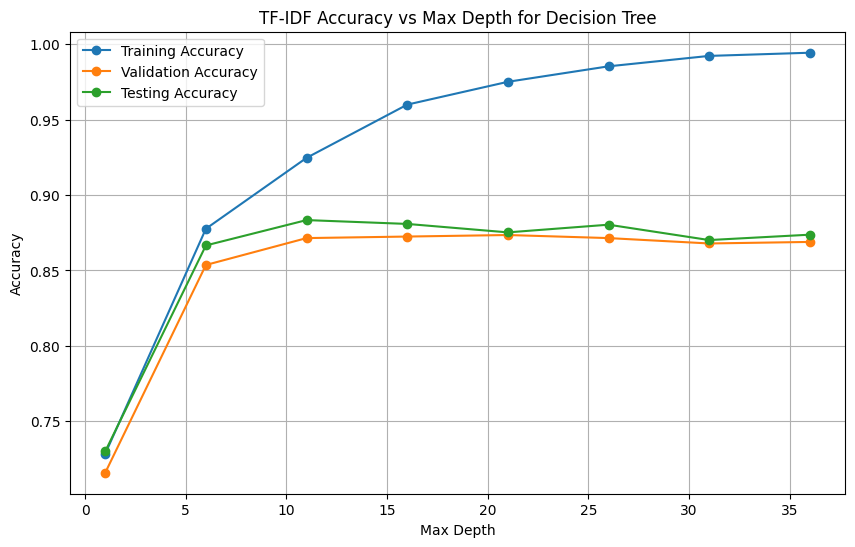

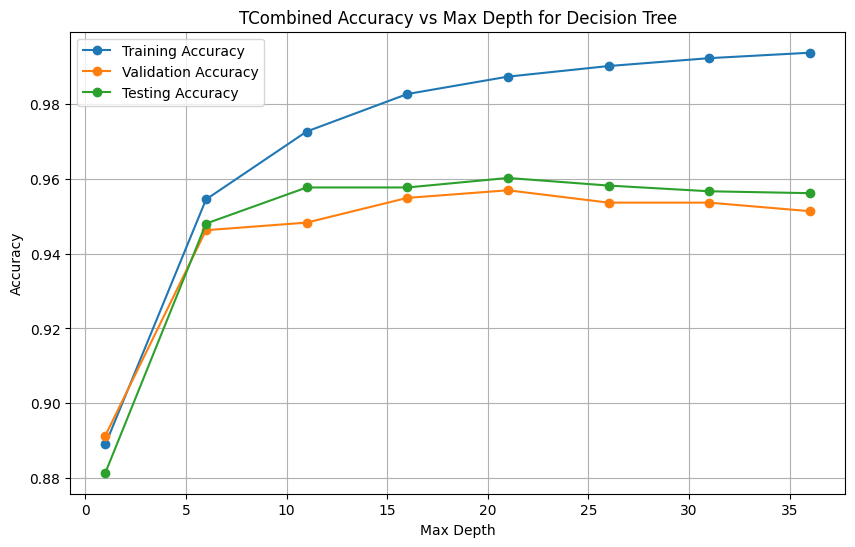

In [ ]:
train_accuracies = []
val_accuracies = []
test_accuracies = []

max_depths = range(1,40,5)
for i in max_depths:
    train, val, test = dt_model(tfidf, max_depth=i, show=False)
    train_accuracies.append(train)
    val_accuracies.append(val)
    test_accuracies.append(test)

plt.figure(figsize=(10, 6))
plt.plot(max_depths, train_accuracies, label='Training Accuracy', marker='o')
plt.plot(max_depths, val_accuracies, label='Validation Accuracy', marker='o')
plt.plot(max_depths, test_accuracies, label='Testing Accuracy', marker='o')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('TF-IDF Accuracy vs Max Depth for Decision Tree')
plt.legend()
plt.grid(True)
plt.show()
    
train_accuracies = []
val_accuracies = []
test_accuracies = []

max_depths = range(1,40,5)
for i in max_depths:
    train, val, test = dt_model(combined, max_depth=i, show=False)
    train_accuracies.append(train)
    val_accuracies.append(val)
    test_accuracies.append(test)

plt.figure(figsize=(10, 6))
plt.plot(max_depths, train_accuracies, label='Training Accuracy', marker='o')
plt.plot(max_depths, val_accuracies, label='Validation Accuracy', marker='o')
plt.plot(max_depths, test_accuracies, label='Testing Accuracy', marker='o')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('TCombined Accuracy vs Max Depth for Decision Tree')
plt.legend()
plt.grid(True)
plt.show()

accuracy_score 0.8772912423625254
precision_score 0.8718232044198895
recall_score 0.8632385120350109
f1_score 0.8675096206706981
roc_auc_score 0.8763811607794101


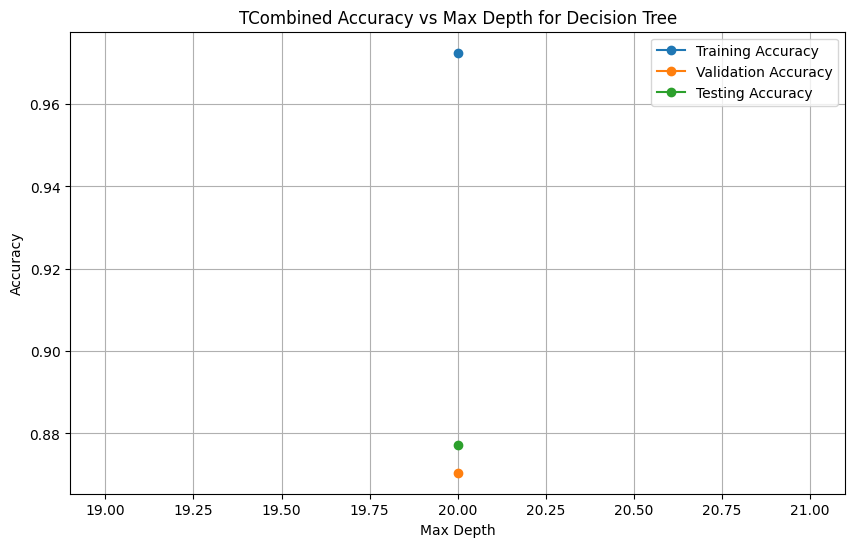

In [204]:
train_accuracies = []
val_accuracies = []
test_accuracies = []
max_depths = [20]
for i in max_depths:
    train, val, test = dt_model(tfidf, max_depth=i, show=True)
    train_accuracies.append(train)
    val_accuracies.append(val)
    test_accuracies.append(test)

plt.figure(figsize=(10, 6))
plt.plot(max_depths, train_accuracies, label='Training Accuracy', marker='o')
plt.plot(max_depths, val_accuracies, label='Validation Accuracy', marker='o')
plt.plot(max_depths, test_accuracies, label='Testing Accuracy', marker='o')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('TCombined Accuracy vs Max Depth for Decision Tree')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(accuracy_score(y_test,  y_pred))
print(f1_score(y_test, y_pred))

0.9541751527494908
0.9504950495049506


In [ ]:
from sklearn.linear_model import Perceptron
def p_model(d):
    p = Perceptron()
    p.fit(d.X_train, d.y_train)
    y_pred = p.predict(d.X_test)
    print("accuracy_score",accuracy_score(d.y_test,  y_pred))
    print("precision_score", precision_score(d.y_test, y_pred))
    print("recall_score", recall_score(d.y_test, y_pred))
    print("f1_score",f1_score(d.y_test, y_pred))
    print("roc_auc_score",roc_auc_score(d.y_test, y_pred))

print("tfidf")
p_model(tfidf)
print("combined")
p_model(combined)

tfidf
accuracy_score 0.9383910386965377
precision_score 0.9169295478443743
recall_score 0.9540481400437637
f1_score 0.9351206434316355
roc_auc_score 0.9394050224028343
combined
accuracy_score 0.9511201629327902
precision_score 0.9595505617977528
recall_score 0.9343544857768052
f1_score 0.9467849223946784
roc_auc_score 0.9500343857455456


In [ ]:
from sklearn.ensemble import RandomForestClassifier
def rf_model(d):
    rf = RandomForestClassifier()
    rf.fit(d.X_train, d.y_train)
    y_pred = rf.predict(d.X_test)
    print("accuracy_score",accuracy_score(d.y_test,  y_pred))
    print("precision_score", precision_score(d.y_test, y_pred))
    print("recall_score", recall_score(d.y_test, y_pred))
    print("f1_score",f1_score(d.y_test, y_pred))
    print("roc_auc_score",roc_auc_score(d.y_test, y_pred))

print("tfidf")
rf_model(tfidf)
print("combined")
rf_model(combined)

tfidf
accuracy_score 0.9042769857433809
precision_score 0.9311163895486936
recall_score 0.8577680525164114
f1_score 0.8929384965831436
roc_auc_score 0.9012649786391581
combined
accuracy_score 0.9516293279022403
precision_score 0.9701492537313433
recall_score 0.9245076586433261
f1_score 0.9467787114845938
roc_auc_score 0.9498728769407107


In [ ]:
from sklearn.naive_bayes import GaussianNB
def gnb_model(d):
    gnb = GaussianNB()
    gnb.fit(d.X_train.toarray(), d.y_train)
    y_pred = gnb.predict(d.X_test.toarray())
    print("accuracy_score",accuracy_score(d.y_test,  y_pred))
    print("precision_score", precision_score(d.y_test, y_pred))
    print("recall_score", recall_score(d.y_test, y_pred))
    print("f1_score",f1_score(d.y_test, y_pred))
    print("roc_auc_score",roc_auc_score(d.y_test, y_pred))

print("tfidf")
gnb_model(tfidf)
print("combined")
gnb_model(combined)

tfidf
accuracy_score 0.8238289205702648
precision_score 0.8107221006564551
recall_score 0.8107221006564551
f1_score 0.8107221006564551
roc_auc_score 0.8229800979472752
combined
accuracy_score 0.824847250509165
precision_score 0.8152654867256637
recall_score 0.8063457330415755
f1_score 0.8107810781078107
roc_auc_score 0.8236490569969782


In [ ]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()

X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

model = GaussianNB()

model.fit(X_train_dense, y_train)

y_pred = model.predict(X_test_dense)

print(accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

0.824847250509165
0.8107810781078107


In [ ]:
# Masks for missing and non-missing values in 'author'
missing_author = data['author'].isnull()
not_missing_author = data['author'].notnull()

# Masks for missing and non-missing values in 'source'
missing_source = data['source'].isnull()
not_missing_source = data['source'].notnull()

# Distribution of 'label' for missing and non-missing 'author'
author_missing_label_dist = data.loc[missing_author, 'label'].value_counts()
author_not_missing_label_dist = data.loc[not_missing_author, 'label'].value_counts()

# Distribution of 'label' for missing and non-missing 'source'
source_missing_label_dist = data.loc[missing_source, 'label'].value_counts()
source_not_missing_label_dist = data.loc[not_missing_source, 'label'].value_counts()

# Print the results
print("Label distribution for missing 'author':")
print(author_missing_label_dist)
print("\nLabel distribution for non-missing 'author':")
print(author_not_missing_label_dist)

print("\nLabel distribution for missing 'source':")
print(source_missing_label_dist)
print("\nLabel distribution for non-missing 'source':")
print(source_not_missing_label_dist)

Label distribution for missing 'author':
label
1    1931
0      26
Name: count, dtype: int64

Label distribution for non-missing 'author':
label
0    10361
1     8482
Name: count, dtype: int64

Label distribution for missing 'source':
label
1    10004
0     1808
Name: count, dtype: int64

Label distribution for non-missing 'source':
label
0    8579
1     409
Name: count, dtype: int64
